In [1]:
# Import packages and set configuration
from IPython.display import display

%load_ext autoreload
%autoreload 2

In [2]:
# Load tickers
tickers = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT", "XRPUSDT", "ADAUSDT", "AVAXUSDT", "DOGEUSDT", "TRXUSDT",
           "DOTUSDT", "LINKUSDT", "SHIBUSDT", "LTCUSDT", "BCHUSDT", "UNIUSDT"]

In [3]:
ps_start = "2024-03-01"
ps_end = "2024-04-01"

trading_start = "2024-03-01"
trading_end = "2024-04-01"

interval = "1h"

In [4]:
# Load data
from modules.data_services.data_pipeline import load_data

df = load_data(
    tickers=tickers,
    start=ps_start,
    end=ps_end,
    interval=interval
)

In [5]:
# Pair Selection
from modules.pair_selection.statistical_tests import johansen_cointegration

joh_df = johansen_cointegration(df)
display(joh_df.head(5))

,pair,trace_stat,crit_95,crit_99,trace_stat - crit_95,trace_stat - crit_99
0,SOLUSDT-ADAUSDT,28.366891,15.4943,19.9349,12.872591,8.431991
1,XRPUSDT-SHIBUSDT,24.592282,15.4943,19.9349,9.097982,4.657382
2,SOLUSDT-DOTUSDT,23.913056,15.4943,19.9349,8.418756,3.978156
3,XRPUSDT-LINKUSDT,22.987367,15.4943,19.9349,7.493067,3.052467
4,DOTUSDT-SHIBUSDT,22.549258,15.4943,19.9349,7.054958,2.614358


In [6]:
fee_rate = 0.0005  # 0.05%
initial_cash = 100000
position_size = 1  # always 100% of portfolio

entry_threshold = 2 # 2 std from z-score
exit_threshold = 0
stop_loss = 1.5 #1.5 of an entry threshold; 150%
rolling_window = 200

In [7]:
# Load pair
from modules.data_services.data_pipeline import load_pair
from modules.data_services.data_utils import pre_training_start

pt_start = pre_training_start(start=trading_start, interval=interval, rolling_window_steps=rolling_window)

# data = load_pair(x=pairs_2[0].split('-')[0], y=pairs_2[0].split('-')[1], start=pt_start, end=trading_end, interval=interval)
data = load_pair(x='SOLUSDT', y='ADAUSDT', start=pt_start, end=trading_end, interval=interval)

Spread liczymy nie jako różnicę znormalizowanych cen (Gatev et al.), tylko jako resztę z regresji liniowej dzięki której wyciągamy betę, która w momencie otwierania pozycji jest naszym parametrem do określania wag aktywów (beta-hedge).
$$Y_t = \alpha + \beta X_t + \epsilon_t$$

In [8]:
# Run strategy
from modules.performance.strategy import run_strategy

data.fee_rate = fee_rate
data.initial_cash = initial_cash

run_strategy(data, rolling_window, entry_threshold, exit_threshold, stop_loss, position_size, is_spread=False, static_hedge=False)
data.data

,SOLUSDT,ADAUSDT,z_score,alpha,beta,mean,std,stop_loss_threshold,weight_x,weight_y,q_x,q_y,cash,signal,position,total_pnl,total_fees,net_pnl,total_pnl_pct,net_pnl_pct
open_time,,,,,,,,,,,,,,,,,,,,
2024-02-29 07:00:00,125.49,0.6836,0.129987,-36.016370,235.918366,4.071410e-14,1.789211,None,None,None,0.000000,0.000000,100000.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-29 08:00:00,131.65,0.6968,1.626782,-38.079628,239.383498,-1.201528e-13,1.799384,None,None,None,0.000000,0.000000,100000.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-29 09:00:00,129.00,0.6915,0.783977,-38.900170,240.762907,5.358913e-13,1.801863,None,None,None,0.000000,0.000000,100000.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-29 10:00:00,128.72,0.7015,-0.648170,-38.257524,239.694882,-5.234568e-13,1.802669,None,None,None,0.000000,0.000000,100000.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-29 11:00:00,129.18,0.6904,0.997668,-39.174759,241.246051,5.478284e-14,1.802690,None,None,None,0.000000,0.000000,100000.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 20:00:00,199.43,0.6490,2.337038,-99.212531,441.632228,-1.722071e-12,5.144639,5.403575,0.002363,0.997637,-1.191095,151501.494821,0.0,-1.0,-1.0,25621.360436,752.020236,24869.340200,0.256214,0.248693
2024-03-31 21:00:00,199.70,0.6461,2.577416,-96.176165,437.092339,5.968559e-14,5.226478,5.403575,0.002363,0.997637,-1.191095,151501.494821,0.0,-1.0,-1.0,26060.393175,752.020236,25308.372939,0.260604,0.253084
2024-03-31 22:00:00,200.62,0.6488,2.476201,-94.070531,433.992690,4.831691e-15,5.296853,5.403575,0.002363,0.997637,-1.191095,151501.494821,0.0,-1.0,-1.0,25650.243331,752.020236,24898.223096,0.256502,0.248982


In [9]:
# Calculate statistics
from modules.performance.strategy import calculate_stats

data.stats = calculate_stats(data)
data.stats

,0% fee,0.05% fee
metric,,
total_return,0.2563,0.2488
cagr,12.7823,11.8631
volatility,0.0080,0.0080
volatility_annual,0.7453,0.7481
max_drawdown,-0.1193,-0.1198
win_count,7.0000,7.0000
lose_count,1.0000,1.0000
win_rate,0.8750,0.8750
max_win,0.1002,0.0998


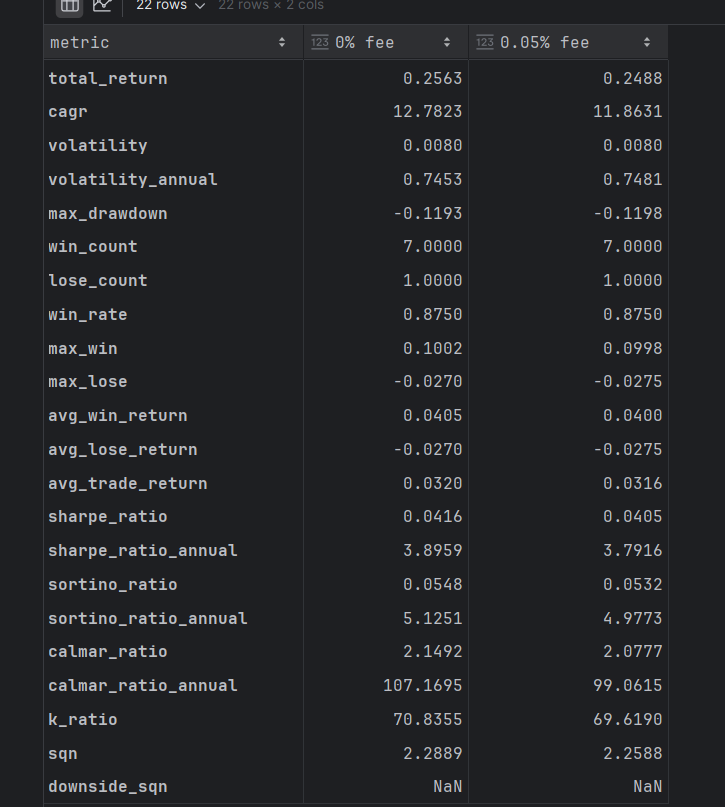

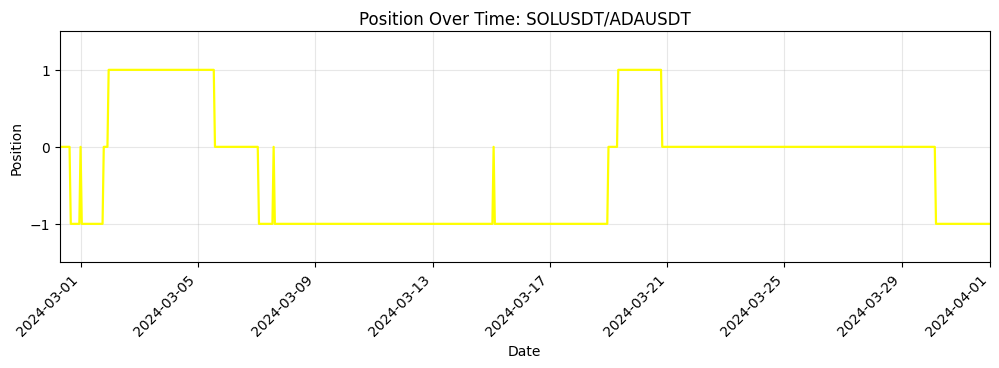

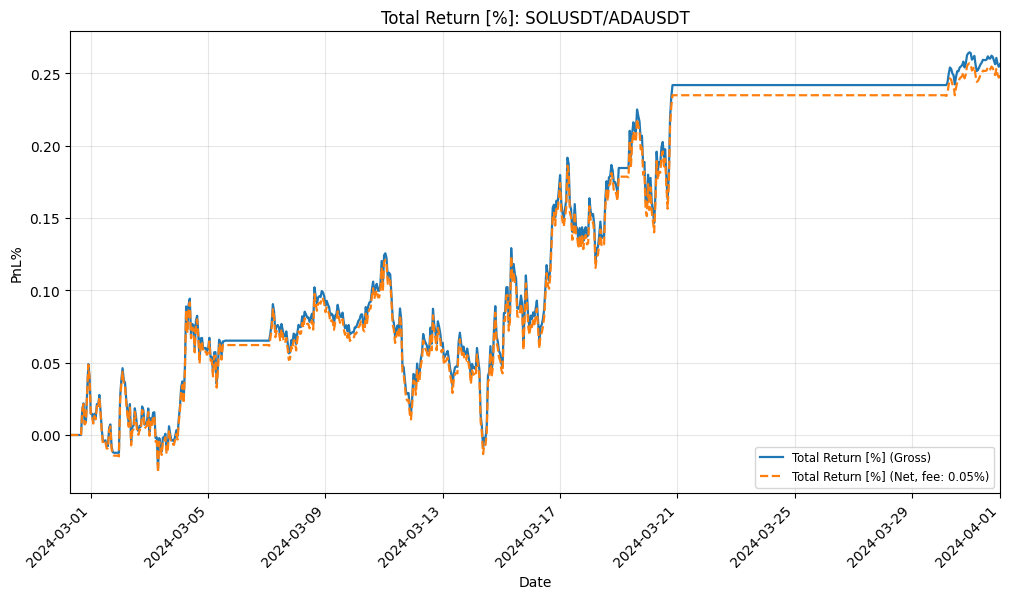

KeyError: 'z_score_virtual'

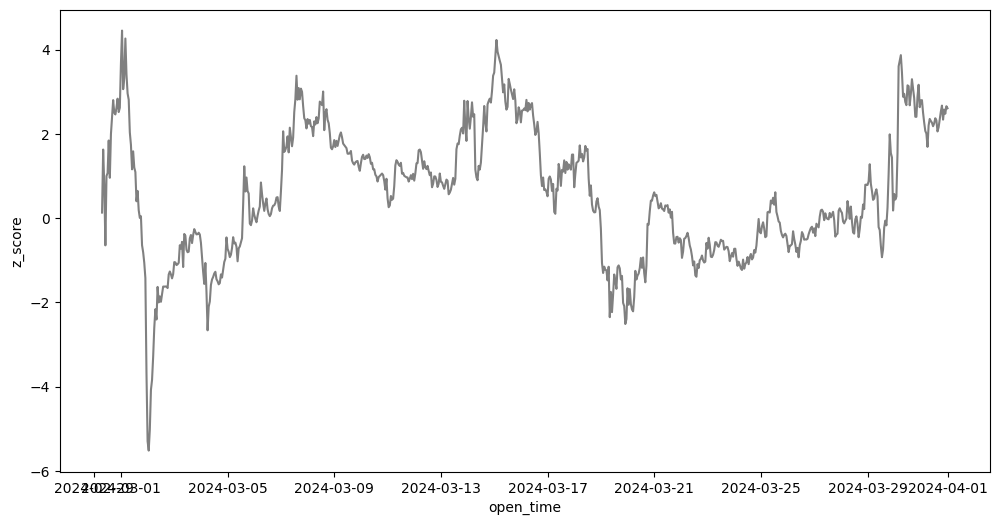

In [10]:
# Visualization
from modules.visualization.plots import plot_pnl, plot_positions, plot_zscore

plot_positions(data, 'strategy', False, True)
plot_pnl(data, 'strategy', False, True)
plot_zscore(data)